In [1]:
# Exmaple for computationally solving ordering of serial sections.
# This example orders 20 sections, downsampled to a pixel resolution of 256 nm.
# Section images downsampled to 128 or 256 nm are recommended.

from SliceOrderSolver import SliceOrderSolver

# set default parameters.
in_dir = 'images'
out_dir = 'ordered'
nthreads = 0
ngpus = 1

# Instantiate the solver using command-line parameters.
solver = SliceOrderSolver(in_dir, out_dir, nthreads, ngpus)

In [2]:
# Load the images and compute keypoints. This should run in 30-60 seconds.
fns, keypoints, descriptors = solver.load_images_and_detect_keypoints()

# Compute the percent matches image similarity (distance) matrix.
# This is computationally expensive, but with a single GPU enabled, it should run in about 5 minutes.
# It will also run when ngpus==0 (when specified above) but will take many hours,
#   even whne a large nthreads is specified (i.e., even when using many cores).
# A GPU-enabled KNN search for the SIFT descriptors, or an approximate KNN search is critical for production usage,
#   in addition to scaling across many nodes (i.e., needs to be process-parallelized and run on a cluster).
percent_matches = solver.compute_percent_matches(fns, keypoints, descriptors)

Loading images and detecting keypoints using 1 threads
	done in 27.352 s
Computing percent matches matrix
	using 1 processes on 1 gpus
	total comparisons = 380
	worker0: started
	using gpu index 0
100 through queue in 97.321 s, worker_cnts:
[100]
100 through queue in 88.930 s, worker_cnts:
[200]
100 through queue in 78.105 s, worker_cnts:
[300]
	worker0: completed
	done in 336.387 s


In [3]:
import numpy as np
from SliceOrderSolver import ANN

# Convert to the symmetric Traveling Salesman Problem.
# Although one could restrict the percent matches computation to upper or lower triangular,
#   the KNN searches are not symmetric, and for challenging ordering locations
#   the full matrix computation is advantageous.
percent_matches_symmetric = np.maximum(np.triu(percent_matches), np.tril(percent_matches).T)
percent_matches_symmetric = percent_matches_symmetric + percent_matches_symmetric.T

# Get minimum path for TSP using nearest neighbor greedy algorithm.
# For production usage an optimal TSP solver is recommended, for example the concorde TSP solver:
# https://www.math.uwaterloo.ca/tsp/concorde.html
path, cost = ANN(1. - percent_matches_symmetric)
print('Proposed slice ordering:')
print(path)

Proposed slice ordering:
[7, 11, 8, 10, 4, 6, 1, 3, 5, 15, 13, 12, 19, 16, 14, 9, 2, 17, 18, 0]


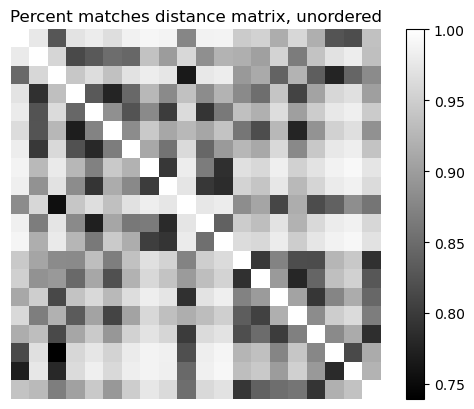

In [4]:
from matplotlib import pyplot as plt

# Plot the distance matrix in the original slice ordering.
plt.figure()
plt.imshow(1 - percent_matches, cmap='gray')
plt.colorbar()
plt.axis('off')
plt.title('Percent matches distance matrix, unordered')
plt.show()

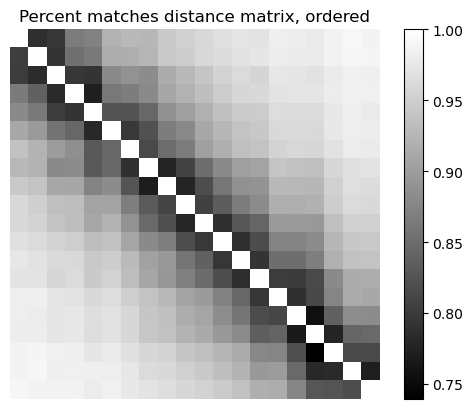

In [5]:
# Plot the distance matrix in the solved ordering.
percent_matches_ordered = percent_matches[path,:]
percent_matches_ordered = percent_matches_ordered[:,path]

plt.figure()
plt.imshow(1 - percent_matches_ordered, cmap='gray')
plt.colorbar()
plt.axis('off')
plt.title('Percent matches distance matrix, ordered')
plt.show()

In [6]:
# Export the images in the solved ordering.
solver.export_proposed_ordering(fns, path)

Exporting images in proposed ordering
	done in 0.613 s
